In [1]:
import torch
import torch.nn as nn
import torchvision
from torchmetrics import PeakSignalNoiseRatio
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

import numpy as np
import datetime, random
import csv, os, argparse, time
import matplotlib.pyplot as plt

from models import CondEnergyModel, UNet, Resneten, autoencoders, REDNet30
from ResNet import IGEBM, EnResnet

from utils import requires_grad, to_numpy, SampleBuffer, get_dataloaders
from utils import UNet_Energy_log, Self_Energy_log, Custom_Dataset, SGLD_, clip_grad


In [2]:
IMG_SIZE = 32
Batch_size = 128
langevin_min = 0.001
langevin_max = 0.01
alpha = 0.1

num_epochs = 50

cuda_device = 2
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')

PSNR = PeakSignalNoiseRatio().to(device)

In [3]:
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(32),
    # torchvision.transforms.RandomCrop(32, padding=4),
    # torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    # torchvision.transforms.Normalize((0.5, ), (0.5, ))
    ])

dir_data = '/hdd1/dataset/'
dataset = datasets.CIFAR10(dir_data, download=True, transform=transforms.ToTensor())
loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=4)
# loader = enumerate(sample_data(loader))

print(len(loader), len(loader)*Batch_size)

Files already downloaded and verified
390 49920


In [4]:
ae = REDNet30()
# ae = ConvAE(32, 256)
ae = ae.to(device)
criterion = nn.MSELoss()
optim_ae = torch.optim.Adam(ae.parameters(), lr=0.0001, betas=(0.5, 0.999))

energy = IGEBM()
energy = energy.to(device)
optim_en = torch.optim.Adam(energy.parameters(), lr=0.0001, betas=(0.5, 0.999))

lr_LD = torch.linspace(langevin_max, langevin_min, steps=num_epochs)

sigmas_np = np.linspace(0.05, 0.5, Batch_size)
sigmas = torch.Tensor(sigmas_np).view((Batch_size, 1, 1, 1)).to(device)

In [5]:
val_loss_en = np.zeros(num_epochs)
val_psnr_arr = np.zeros(num_epochs)

for i in range(num_epochs):
    # loss_ae_l = list()
    # loss_en_l = list()
    psnr_l = list()
    for image, label in loader:
        image = image.to(device)
        noisy_image = image + sigmas * torch.randn_like(image)
        
        outputs = ae(noisy_image)
        
        requires_grad(energy, False)
        energy.eval()
        neg_img = SGLD_(outputs.detach(), noisy_image, energy, 10, lr_LD[i])
        
        ae.train()
        optim_ae.zero_grad()
        loss_ae = criterion(neg_img, outputs)
        loss_ae.backward()
        optim_ae.step()
        
        ae.eval()
        requires_grad(energy, True)
        energy.train()
        
        energy.zero_grad()
        pos_out = energy(noisy_image, image)
        neg_out = energy(noisy_image, neg_img.detach())
        # print(torch.mean(neg_out), torch.mean(pos_out))
        
        cd_loss =  pos_out - neg_out
        reg_loss =  alpha * (torch.square(pos_out) + torch.square(neg_out))
        loss_en = cd_loss + reg_loss
        loss_en = loss_en.mean()
        loss_en.backward()
        
        clip_grad(energy.parameters(), optim_en)
        optim_en.step()
        
        val_psnr = to_numpy(PSNR(outputs, image))
        val_psnr_LD = to_numpy(PSNR(neg_img, image))
        # loss_en_l.append(loss_ae.item())
        psnr_l.append(val_psnr)
                
    # val_loss_en[i] = np.mean(loss_en)
    val_psnr_arr[i] = np.mean(val_psnr)
    
    print(f"Epoch [{i+1}/{num_epochs}], AE_Loss: {loss_ae.item():.6f}, EN_Loss: {loss_en.item():.6f}, PSNR: {val_psnr:.6f}, PSNR LD: {val_psnr_LD:.6f}")

/nas/users/minhyeok/energy_based_model/baseline/utils.py:257: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  x.data.add_(-lr_rate, x.grad.data)


Epoch [1/50], AE_Loss: 0.000000, EN_Loss: -4.983084, PSNR: 11.339009, PSNR LD: 11.339009


KeyboardInterrupt: 

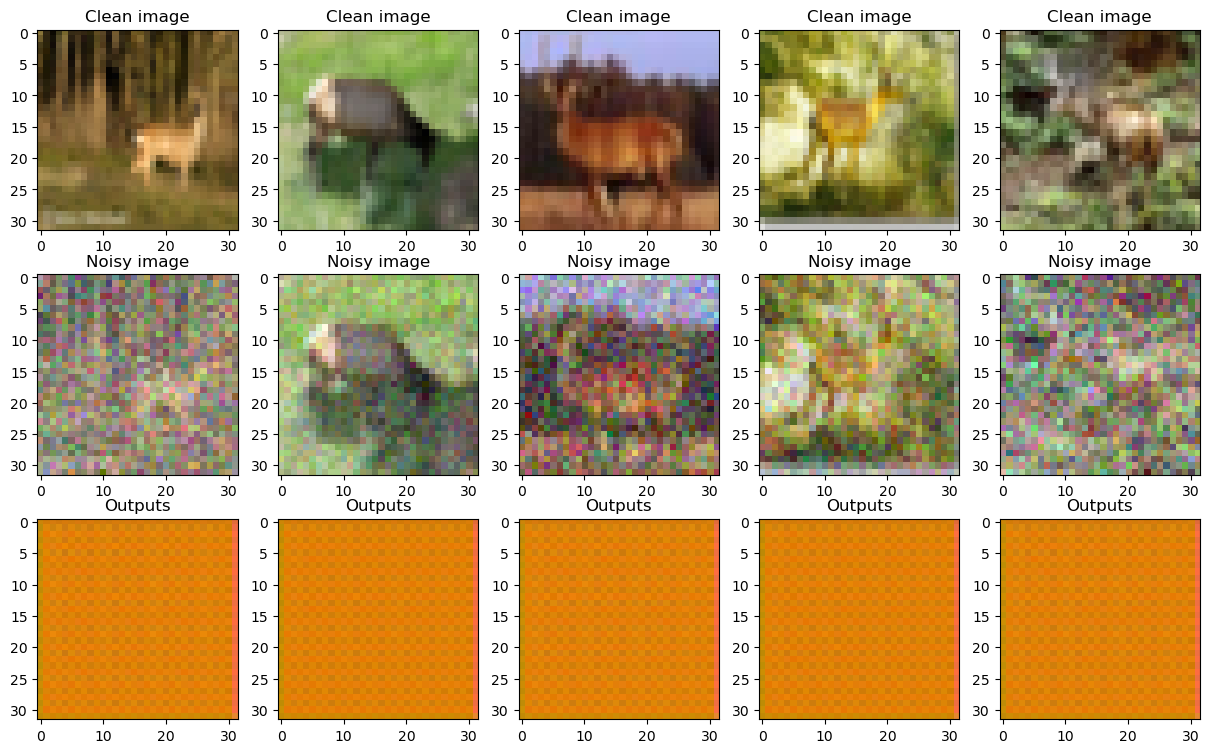

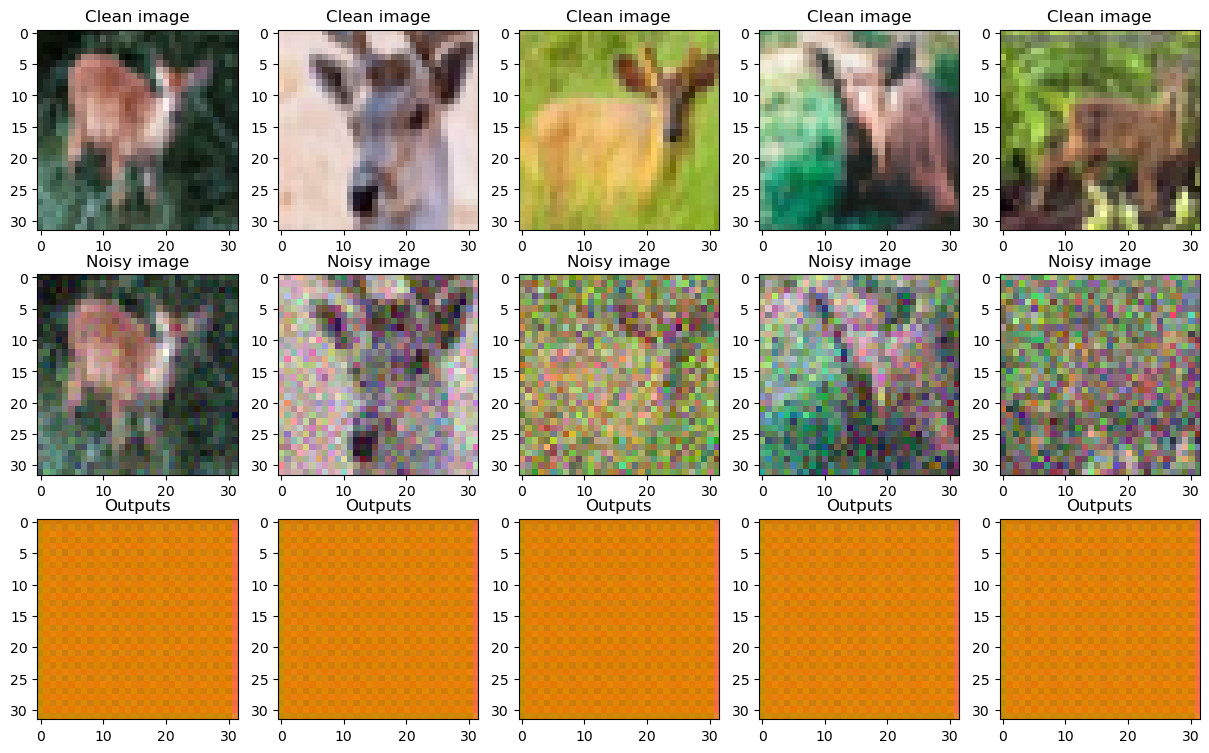

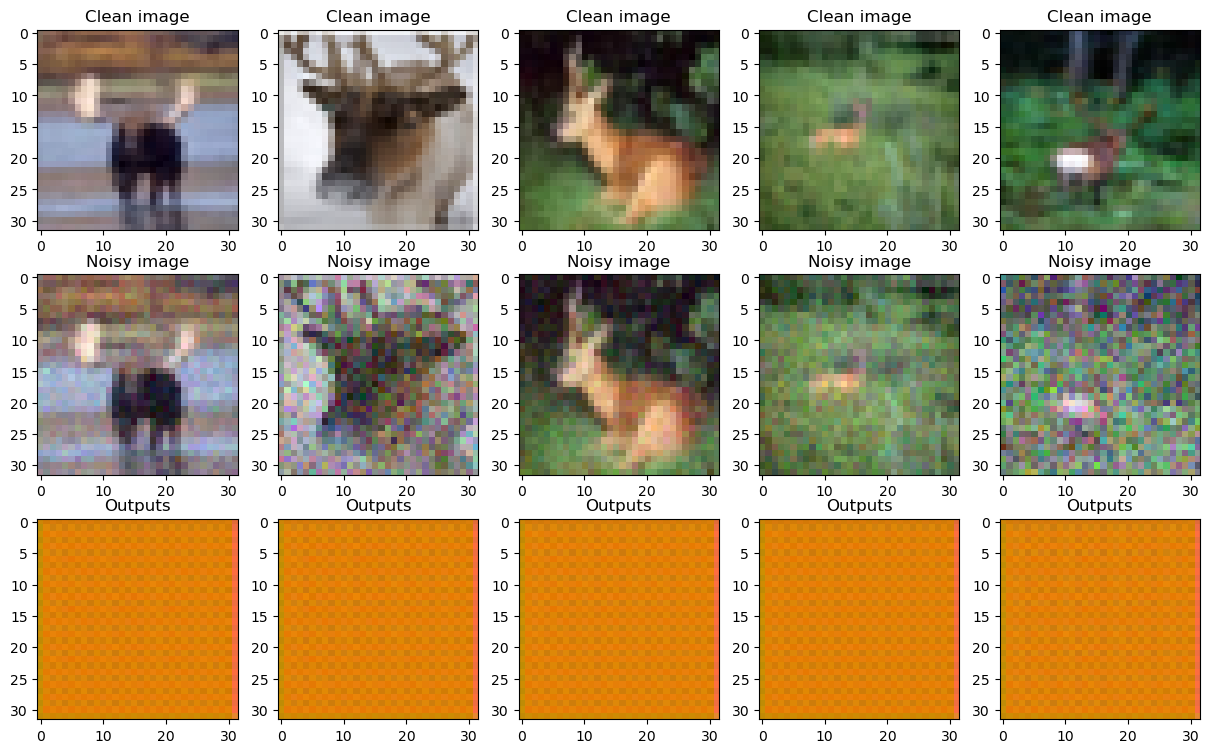

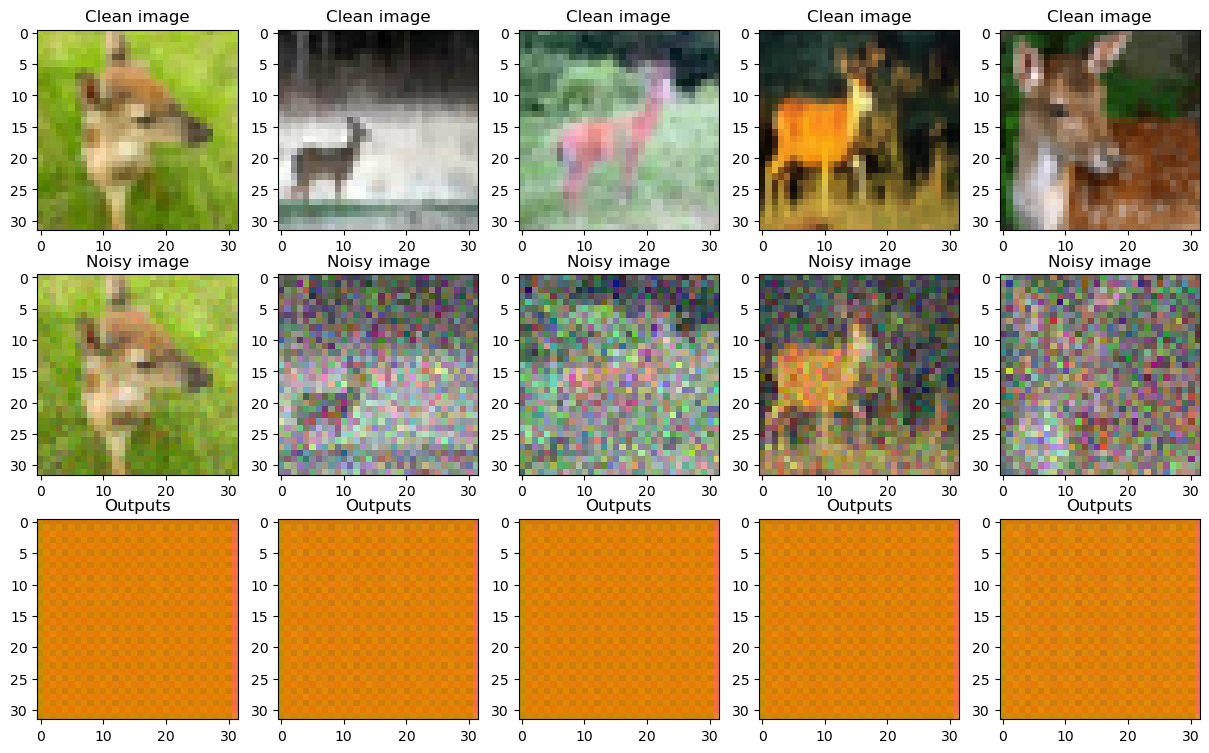

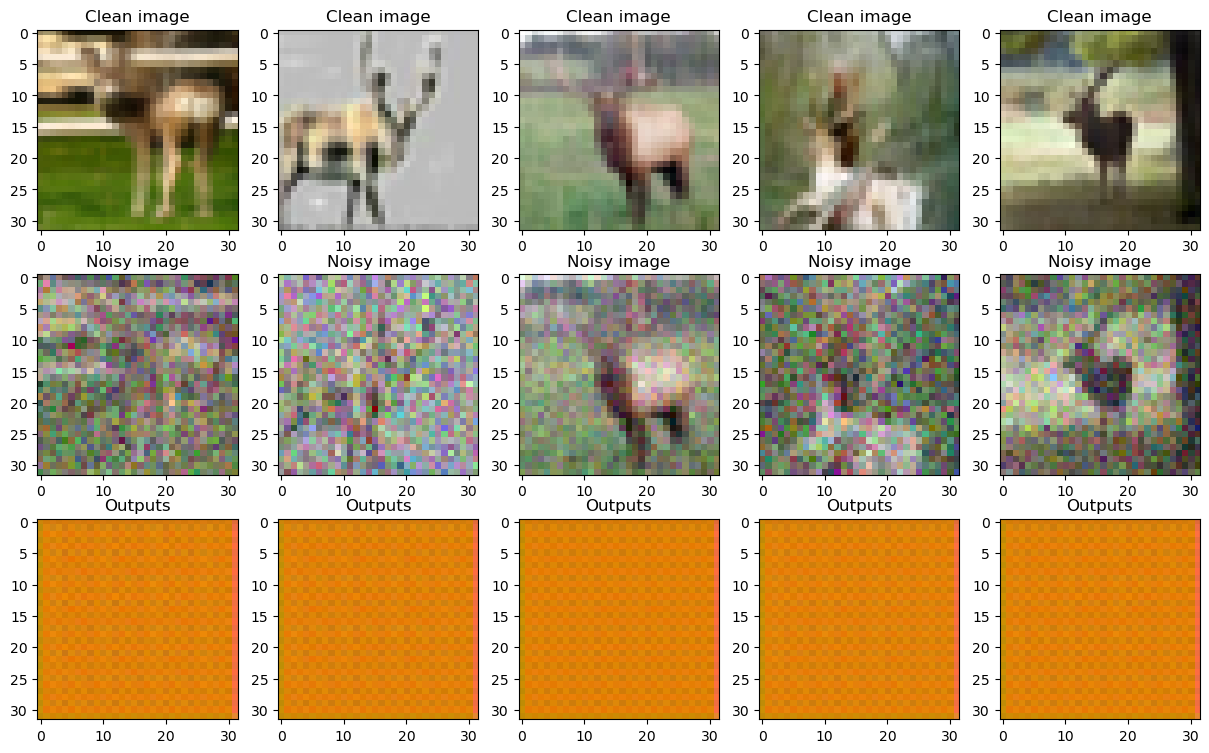

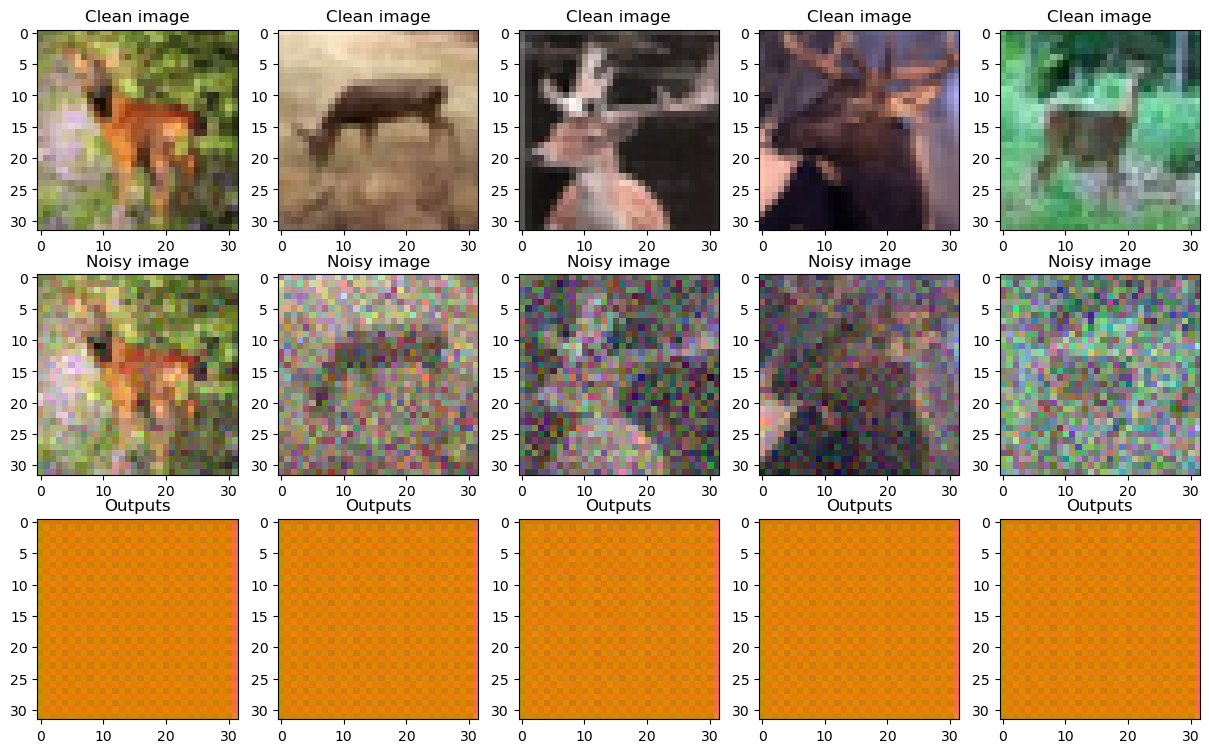

In [9]:
ae.eval()
row = 3
col = 5

for j, (test_img, _) in enumerate(iter(loader)):
    
    test_img = test_img.to(device)
    noisy = test_img + sigmas * torch.randn_like(test_img)
    out_img = ae(noisy)
    
    fig, ax = plt.subplots(row, col, figsize = (3*col, 3*row))
    for k in range(col):
        rand = random.randrange(Batch_size)
        ax[0][k].set_title("Clean image")
        ax[0][k].imshow(torchvision.utils.make_grid(test_img[rand].detach().cpu(), normalize=True).permute(1,2,0))
        ax[1][k].set_title("Noisy image")
        ax[1][k].imshow(torchvision.utils.make_grid(noisy[rand].detach().cpu(), normalize=True).permute(1,2,0))
        ax[2][k].set_title("Outputs")
        ax[2][k].imshow(torchvision.utils.make_grid(out_img[rand].detach().cpu(), normalize=True).permute(1,2,0))